Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [59]:
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from itertools import accumulate
from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [60]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.1

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [61]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

## Helper Functions

In [62]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Improved RHMC

In [64]:
def one_lambda_es(solution : np.ndarray, strength : float, Lambda : int ) -> np.ndarray:
    CHILDREN = np.empty((Lambda, NUM_SETS), dtype=bool)
    for child in range(Lambda):
        mask = rng.random(NUM_SETS) < strength
        if not np.any(mask):  
            mask[np.random.randint(NUM_SETS)] = True
        CHILDREN[child] = np.logical_xor(solution, mask)
    
    return CHILDREN


In [65]:
#Fitness functioon

def fitness(solution: np.ndarray) :
    return (valid(solution), -cost(solution))

## Hill climber

ic| fitness(solution): (np.True_, np.float64(-1991578.7707485426))
ic| fitness(solution): (np.True_, np.float64(-119626.31151318751))


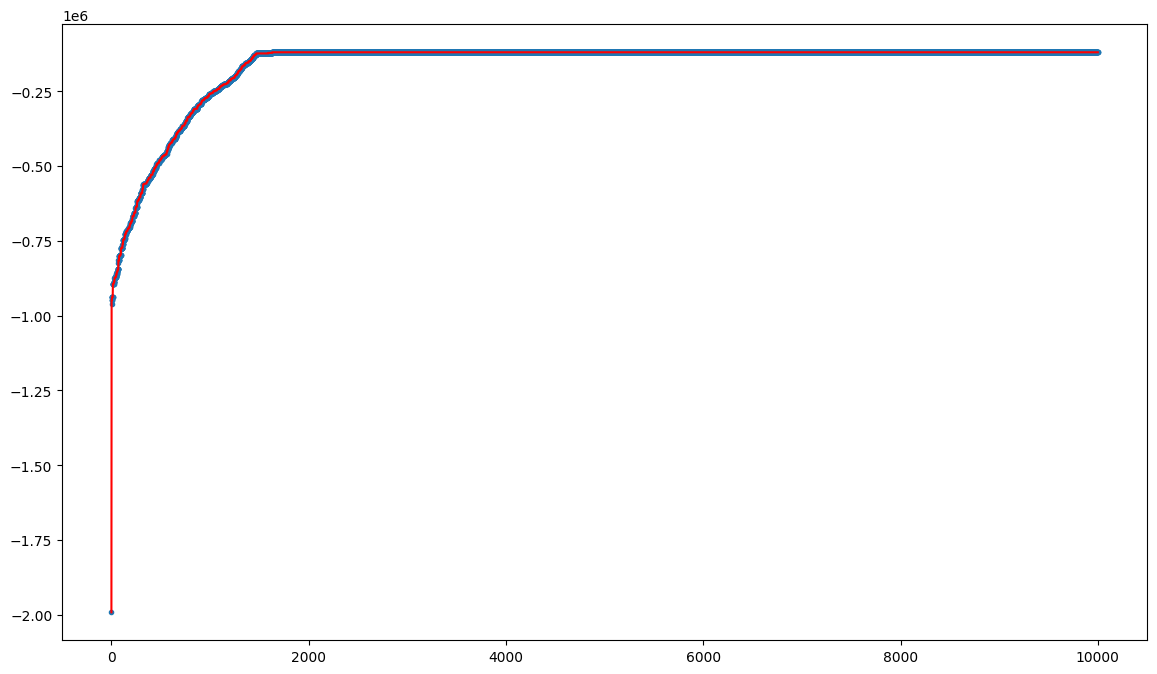

In [68]:
BUFFER_SIZE = 5 #rule of one out of five
Lambda = 10

#Initialization
solution = rng.random(NUM_SETS) < 1  
solution_fitness = fitness(solution)[1]
history = [float(solution_fitness)]
ic(fitness(solution))

#"Simulated Annealing" 
strength = 0.5
buffer = list()

for steps in range (10_000):
    #using one_lambda_method
    new_solutions = one_lambda_es(solution, strength, Lambda)

    best_fitness=solution_fitness 
    new_solution=solution  

    # Parcourir chaque enfant généré
    for i in range(Lambda):
        valid_solution, f = fitness(new_solutions[i]) 
        if valid_solution and f > best_fitness: 
            best_fitness = f  
            new_solution = new_solutions[i]  

    history.append(float(best_fitness))

    #1 out of 5 method
    buffer.append(best_fitness > solution_fitness)
    buffer = buffer[-BUFFER_SIZE:]  

    if sum(buffer) > 1:  
        strength *= 1.1
    elif sum(buffer) == 0:  
        strength /= 1.1

    if best_fitness > solution_fitness:
        solution = new_solution
        solution_fitness = best_fitness

#ic(solution)
ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")